In [7]:
import unittest

import torch

from retention import SimpleRetention, MultiScaleRetention
from retnet import RetNet


import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io

from util import *

In [8]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [13]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones
# from src.retention import SimpleRetention, MultiScaleRetention
from retnet import RetNet

#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度,输出的形状为(点的数量，序列长度，d_model)

        # self.retnet = RetNet(layers = 4, hidden_size = d_model, ffn_size = 128, heads = heads, double_v_dim=True)
        
        self.retnet = RetNet(4, d_model, 128, heads, double_v_dim=False)
        # self.encoder = Encoder(d_model, N, heads) #编码器层
        # self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, t): #输入的x和t形状一般为(点的数量, 序列长度, 1)
        src = torch.cat((x,t), dim=-1) #将x和t沿最后一个维度拼接，形成输入的特征向量，形状变为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        # e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        # d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.retnet(src) #使用RetNet处理输入特征向量，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output = self.linear_out(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output


In [9]:
device = 'cuda:0'

In [10]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

C:\Users\lcy\AppData\Local\Temp\ipykernel_581876\1725142899.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (retnet): RetNet(
    (retentions): ModuleList(
      (0-3): 4 x MultiScaleRetention(
        (group_norm): GroupNorm(2, 32, eps=1e-05, affine=True)
        (retentions): ModuleList(
          (0-1): 2 x SimpleRetention(
            (xpos): XPOS()
          )
        )
      )
    )
    (ffns): ModuleList(
      (0-3): 4 x Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=32, bias=True)
      )
    )
    (layer_norms_1): ModuleList(
      (0-3): 4 x LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (layer_norms_2): ModuleList(
      (0-3): 4 x LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (linear_out): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): WaveAct()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3):

In [15]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + 50 * u_x) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss
    
    optim.step(closure)

100%|██████████| 500/500 [11:58<00:00,  1.44s/it]


In [16]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.003019, Loss_BC: 0.022516, Loss_IC: 0.074945
Train Loss: 0.100480


In [18]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

mat = scipy.io.loadmat('/convection.mat')
u = mat['u'].reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

relative L1 error: 1.119232
relative L2 error: 1.237570


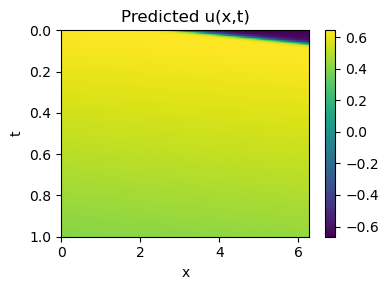

In [20]:
mat = scipy.io.loadmat('convection.mat')
u = mat['u'].reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()

In [3]:
print("Input shape:", X.shape)
print("Output shape:", Y_parallel.shape)

Input shape: torch.Size([2, 5, 36])
Output shape: torch.Size([2, 5, 36])
